*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

# GDCC ANYmal Dataset Profiling 

### GDCC to solve QPs on Loihi

In [1]:
import numpy as np
from scipy.spatial import distance
from scipy import sparse
import matplotlib.pyplot as plt
import time
import os
import osqp

### Function Calls

In [2]:
def ruiz_equilibriation(matrix, iterations):
    #tic = time.time()
    m_bar = matrix 
    left_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[0]))
    right_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[1]))
    row_del, col_del = 0, 0
    for i in range(iterations):
        D_l_inv = sparse.csc_matrix(np.diag(1/np.sqrt(np.linalg.norm(m_bar, ord=2, axis=1))))
        if(m_bar.shape[0] != m_bar.shape[1]):
            D_r_inv = sparse.csc_matrix(np.diag(1/np.sqrt(np.linalg.norm(m_bar, ord=2, axis=0))))
        else:
            D_r_inv = D_l_inv
            
        m_bar = D_l_inv@m_bar@D_r_inv
        left_preconditioner = left_preconditioner@D_l_inv
        #right_preconditioner = right_preconditioner@D_r_inv
        row_del = np.max(np.abs(1-np.linalg.norm(m_bar, ord=2, axis=1))) 
    print(row_del)
    #print(time.time()-tic)
    return left_preconditioner, right_preconditioner

In [3]:
# Euler timestep integration, we use h=1 in this notebook
def x_next_euler(ode, h, x_curr, *args):
    '''
    Function that performs euler integration for gradient dynamics given by ode argument. The integration timestep is h. 
    The *args argument is specified to supply arguments for the ode function reference.
    '''
    return x_curr + ode(*args, x_curr) * h

def constraint_check_graded_spikes(A, x, spk_threshold):
    '''
    Graded spike generation from the constraint check layer. The spk threshold is b in Ax > b. Graded spikes are sent from neurons
    that violate the constraint corresponding to the neuron. The correction is equal to the perpendicular distance of the current 
    iterate of x from the constraint hyperplane(s) that it violates in the direction of the normal to the hyperplane.
    '''
    g_spk = ((A@x)-spk_threshold)*(((A@x) > spk_threshold))  # fire if constraints are violated. Firing magnitute specified by
                                                          # amount of constraint violation  
    return g_spk   

def GD_NQP_dxdt(P, p, A, s_G_t, beta, alpha, x):
    '''
    Constraint-corrected Gradeint descent dynamics. The dynamics are vanilla gradient descent corrected by a factor
    of A.T @ s_G_T where A.T specifies the direction of correction and s_G_T specifies the amount by which the correction 
    needs to happen (the graded spiking from the spiking layer).
    '''
    # The gradient correction is multiplied by an increasing parameter as it gets closer to the solution 
    # parameter controls how close we get to the solution
    dxdt = -alpha*(P@x + p) - beta*A.T @ s_G_t
    # print("The gradient descent is {} and constraint check is {}".format((alpha*(P@x + p)).T, (A.T @ s_G_t).T))
    #dxdt = -alpha*(P@x + p) 
    return dxdt

### Run GDCC Analyses on all files in dataset

In [24]:
scale = "full"
path = "qp/data/anymal_"+scale+"_scale/"
file_list=os.listdir(path)

multi_prob_per_sol_error = []
alpha_decay_indices_list = [35, 100, 200, 350, 600, 900]
beta_growth_indices_list = [1, 3, 7, 15, 31, 63, 127, 255, 511, 900]

k_max = 1000

for file in file_list:
    a = np.load(path+file)
    Q, A, p, k = [a[i] for i in a] 
    
    # OSQP reference
    Q_ref = sparse.csc_matrix(Q)
    A_ref = sparse.csc_matrix(A)
    l_eq = k
    u_eq = k
    #create OSQP object
    prob = osqp.OSQP()
    prob.setup(Q_ref, p, A_ref, l_eq, u_eq, warm_start=False)
    res = prob.solve()
    opt_sol = res.x.reshape((res.x.shape[0], 1))
    opt_objective =  res.info.obj_val
    
    toc = time.time()
    
    # equality constrainted problem
    A_eq = np.vstack((A,-A))
    k_eq = np.vstack((k,-k))
    
    # matrix preconditioning
    pre_mat_Q, _ = ruiz_equilibriation(Q, 20)
    Q_pre = pre_mat_Q@Q@pre_mat_Q
    p_pre = pre_mat_Q@p

    pre_mat_A, _ = ruiz_equilibriation(A_eq, 10)
    A_pre = pre_mat_A@A_eq@pre_mat_Q
    k_pre = pre_mat_A@k_eq

    
    # GDCC init
    step_size = 1
    alpha = 0.15
    beta = 0.04
    decay_schedule = 50
    x = np.random.rand(res.x.shape[0], 1) 
    
    sol = []
    constraint_sat = []
    cost = []
    
    
    # momentum terms
    u_prev = 0 
    gamma_m = 1
    
    for i in range(k_max):
        if (i%decay_schedule==0 and i!=0):
            alpha=alpha/2
        x_prev = x
        s_G_t = constraint_check_graded_spikes(A_pre, x, k_pre)
        x = x_next_euler(GD_NQP_dxdt, step_size, x, Q_pre, p_pre, A_pre, s_G_t, beta, alpha)
        x = (1-gamma_m)*x + gamma_m*x_prev
        u = (1+np.sqrt(1+4*pow(u_prev,2)))/2 
        u_next = (1+np.sqrt(1+4*pow(u,2)))/2
        gamma_m = (1 - u)/u_next
        u_prev = u
        
        #cost.append(np.abs((z.T@H_pre@z/2 + h_pre.T@z) - opt_objective)/np.abs(opt_objective)*100)
        sol.append(pre_mat_Q@x)
        #constraint_sat.append(np.linalg.norm(G_pre@z - g_pre))
    cons_vio = [np.linalg.norm(A_eq@s - k_eq) for s in sol]
    err_sol = [np.linalg.norm(res.x.reshape((res.x.shape[0], 1)) - s) for s in sol]
    err_sol_percent = [np.linalg.norm(opt_sol - s)/np.linalg.norm(opt_sol)*100 for s in sol] 
    print("Found solution in {} seconds with error of {}% and constraint violation {}".format(
        time.time() - toc, err_sol_percent[-1], np.linalg.norm(A_eq@sol[-1]-k_eq)))
    multi_prob_per_sol_error.append(cons_vio)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 24660
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.7915e+05   3.33e-02   1.81e+00   1.00e-01   3.54e-02s
  25  -2.7966e+05   2.90e-06   8.50e-06   1.00e-01   6.27e-02s

status:               solved
number of 

5.738147734746235e-09
0.3147298525461961
Found solution in 201.56227254867554 seconds with error of 0.7563600911491662% and constraint violation 26.67844506276095
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 27256
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   

### Plot all solution errors

In [25]:
error_data = np.array(multi_prob_per_sol_error)
std_err = np.std(error_data, axis=0)
mean_err = np.mean(error_data, axis=0)
min_err = np.min(error_data, axis=0)
max_err = np.max(error_data, axis=0) 

Text(0.5, 0, 'Iterations')

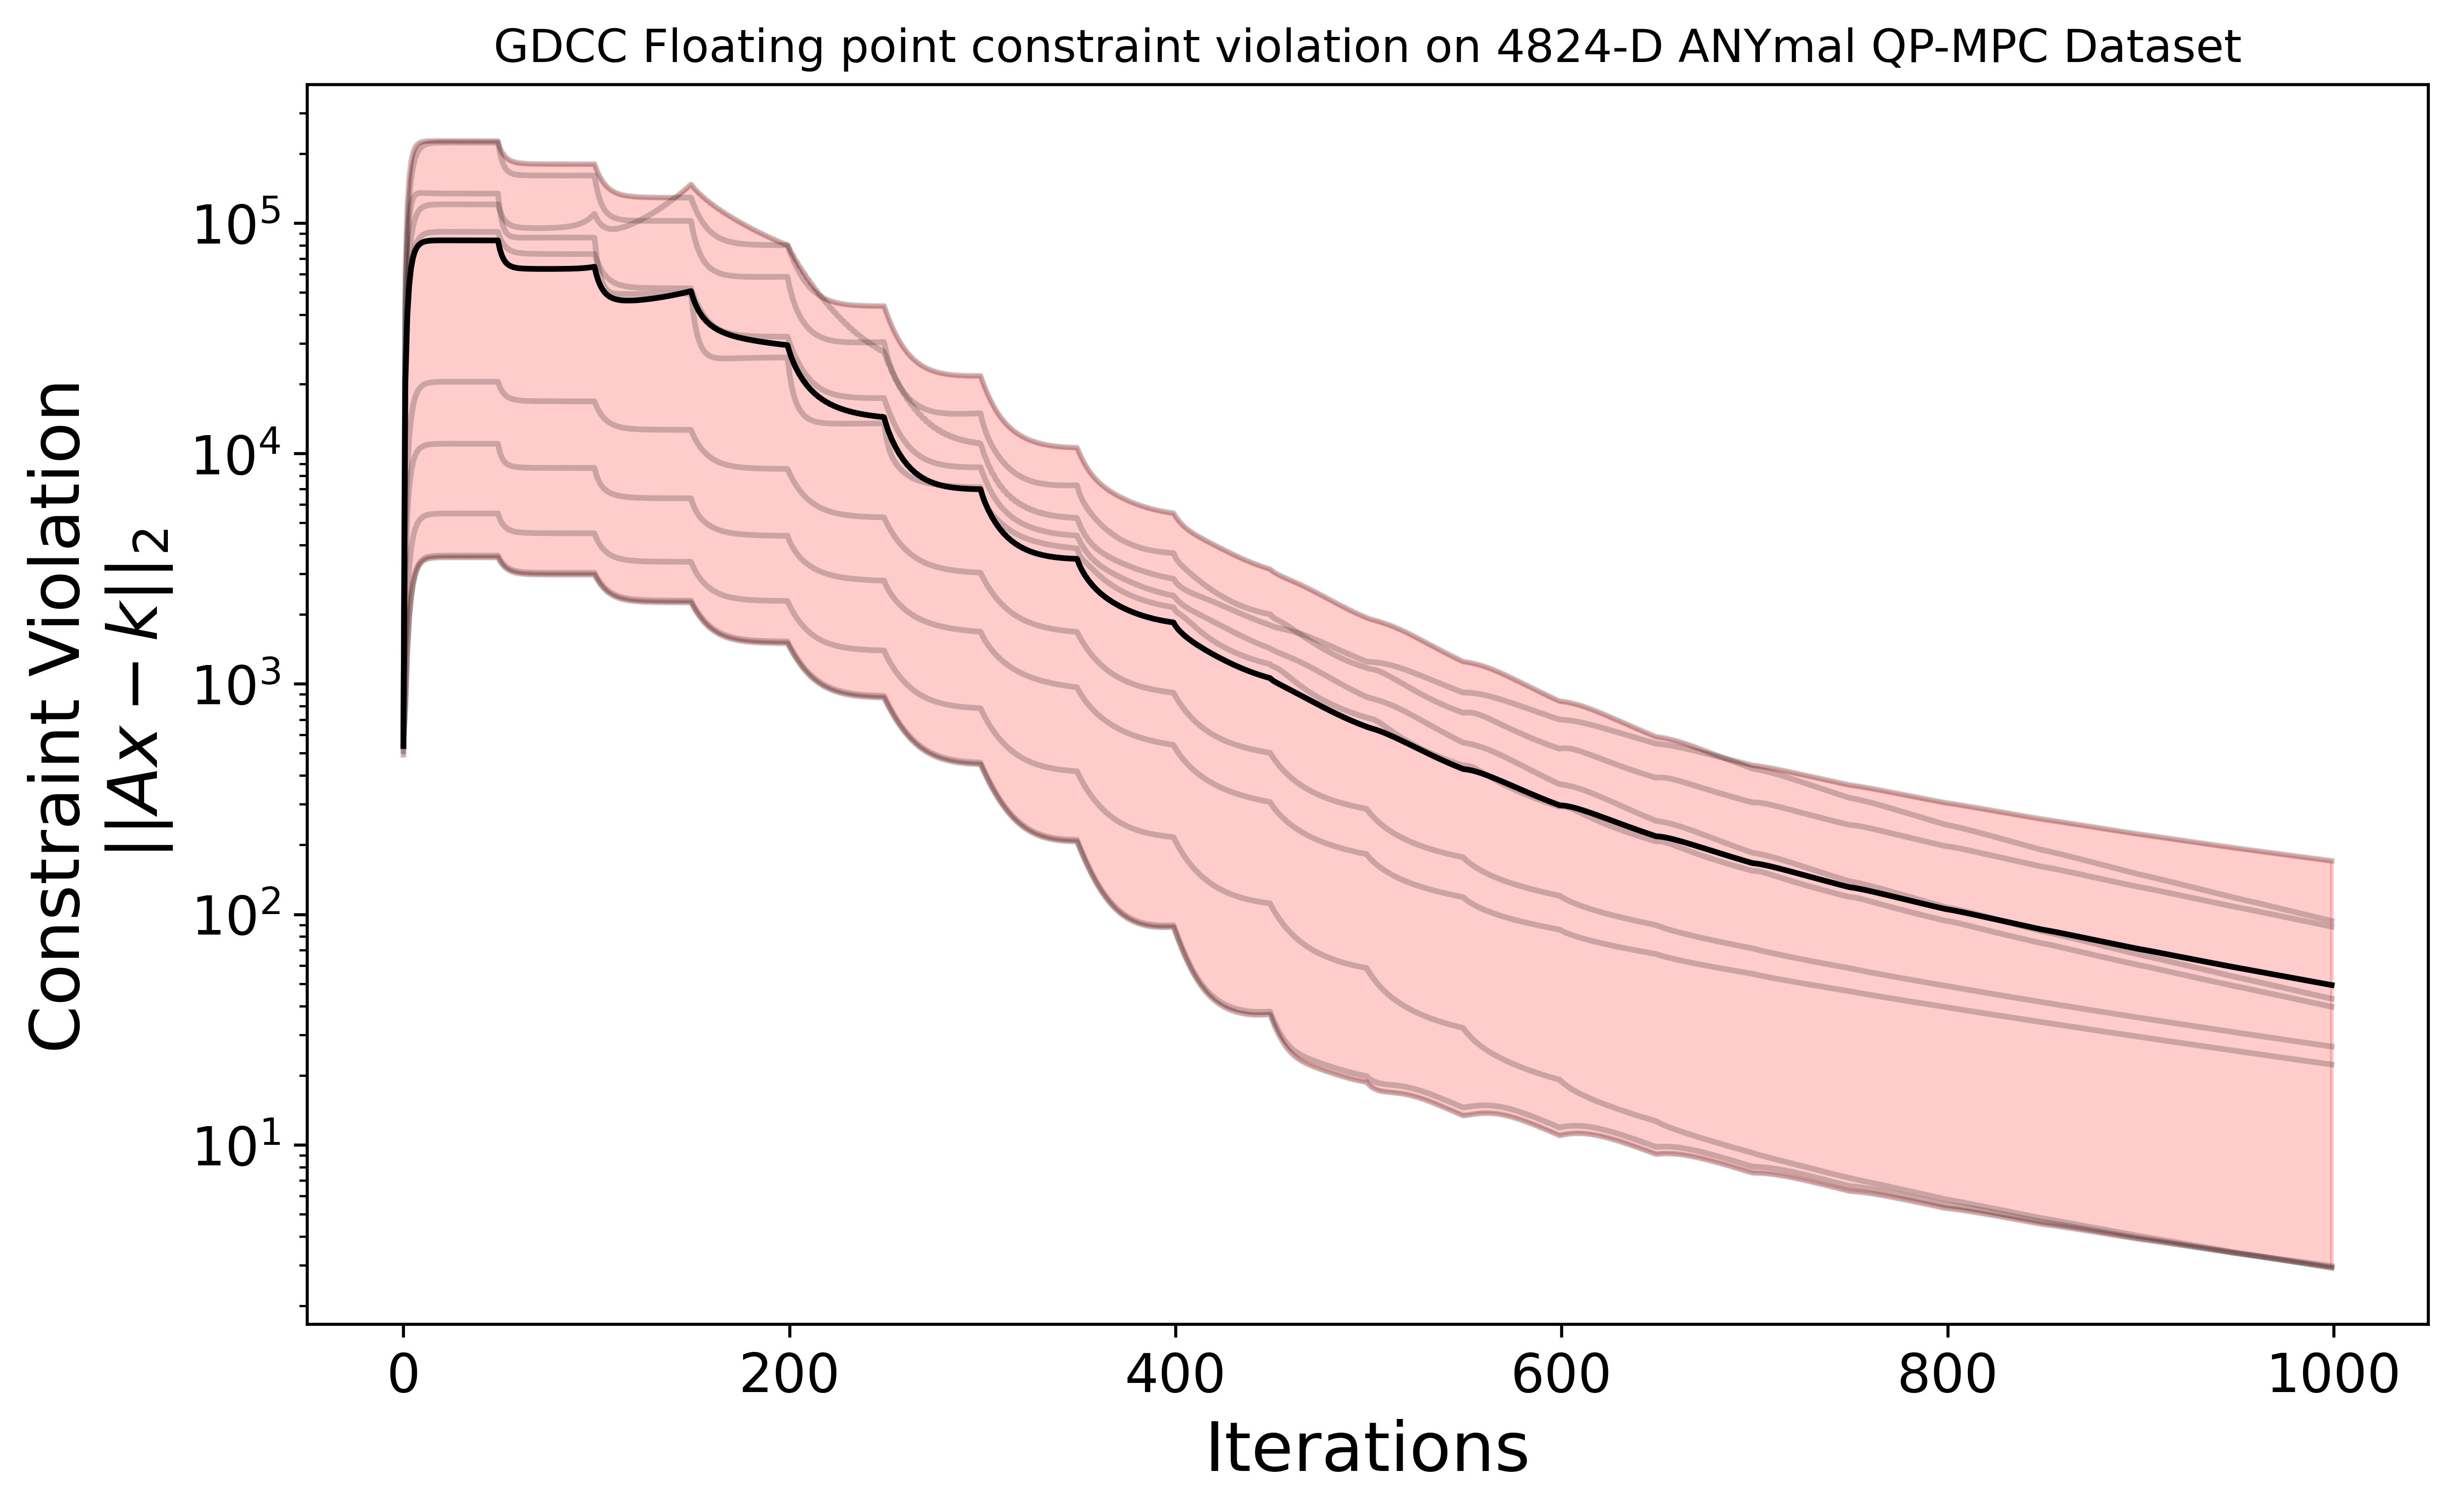

In [26]:
fig,ax = plt.subplots(figsize=(10, 6), dpi=600)
plt.rcParams.update({'font.size': 14})
# plt.title("GDCC convergence to solution on 4824-D ANYmal QP-MPC Dataset", fontsize=14)
plt.title("GDCC Floating point constraint violation on 4824-D ANYmal QP-MPC Dataset", fontsize=12)
for error in multi_prob_per_sol_error:
    ax.plot(error[:], color='black', alpha=0.2)
ax.fill_between(range(0,k_max), min_err, max_err, color='red', alpha=0.2)
ax.plot(mean_err, color='black')
ax.set_ylabel("\n $ ||x*-x||_2/||x*||_2} $ *100",color="blue",fontsize=18)
ax.set_ylabel("Constraint Violation \n $ ||Ax-k||_2} $",color="black",fontsize=18)
ax.set_yscale('log')

# set x-axis label
ax.set_xlabel("Iterations",fontsize=18)

### Lava PIPG Sparsification analysis

Now we put things together and run the PIPG solver in Lava

In [5]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.lib.optimization.solvers.qp.models import (
    ConstraintCheck,
    GradientDynamics,
    SigmaNeurons,
    DeltaNeurons
)

In [6]:
scale = "full"

In [7]:
path = "qp/data/anymal_"+scale+"_scale/"
file_list=os.listdir(path)

In [8]:
multi_prob_grad_dir_ct = []
multi_prob_grad_dir_at = []

multi_prob_accuracy_red_ct = []
multi_prob_accuracy_red_at = []

multi_prob_relative_ops_ct = []
multi_prob_relative_ops_at = []

iterations = 1000

for file in file_list:
    a = np.load(path+file)
    Q, A, p, k = [a[i] for i in a] 
    
    # OSQP reference
    Q_ref = sparse.csc_matrix(Q)
    A_ref = sparse.csc_matrix(A)
    l_eq = k
    u_eq = k
    #create OSQP object
    prob = osqp.OSQP()
    prob.setup(Q_ref, p, A_ref, l_eq, u_eq, warm_start=False)
    res = prob.solve()
    opt_sol = res.x.reshape((res.x.shape[0], 1))
    opt_objective =  res.info.obj_val
    
    toc = time.time()
    
    # matrix preconditioning
    pre_mat_Q, _ = ruiz_equilibriation(Q, 10)
    Q_pre = pre_mat_Q@Q@pre_mat_Q
    p_pre = pre_mat_Q@p
    
        # equality constrainted problem
    A_eq = np.vstack((A,-A))
    k_eq = np.vstack((k,-k))
    
    pre_mat_A, _ = ruiz_equilibriation(A_eq, 10)
    A_pre = pre_mat_A@A_eq@pre_mat_Q
    k_pre = pre_mat_A@k_eq
    
    # GDCC starts here
    # GDCC constants
    init_sol = np.zeros((Q_pre.shape[0], 1))
    alpha_d, beta_g = 50, 10000
    alpha, beta = 0.15, 0.04

       
    # Reference solution run 
    
    # Initialize the ConstraintCheck Process of the QP
    ConsCheck = ConstraintCheck(constraint_matrix=A_pre,
                                constraint_bias=k_pre,
                                )
    # Initialize the Gradient Dynamics process of the QP
    GradDyn = GradientDynamics(hessian=Q_pre, 
                               constraint_matrix_T=A_pre.T,
                               qp_neurons_init=init_sol, 
                               grad_bias=p_pre, alpha=alpha, 
                               beta=beta, 
                               alpha_decay_schedule=alpha_d,
                               beta_growth_schedule=beta_g,
                               )

    # Connect the two hierarchical processes to form core QP 
    # solver
    GradDyn.s_out.connect(ConsCheck.s_in)
    ConsCheck.s_out.connect(GradDyn.s_in)

    toc = time.time()
    # Enable select_sub_proc_model to run subprocess models
    GradDyn.run(condition=RunSteps(num_steps=iterations),
                run_cfg=Loihi1SimCfg(select_sub_proc_model=True)
               )
    
    # profiling counters
    tot_synops = GradDyn.vars.qC_synops.get() + GradDyn.vars.cN_synops.get() + GradDyn.vars.sN_synops.get() \
                + ConsCheck.vars.cNeur_synops.get() + ConsCheck.vars.cD_synops.get() 
    tot_spikeops = GradDyn.vars.qC_spikeops.get() + GradDyn.vars.cN_spikeops.get() + GradDyn.vars.sN_spikeops.get() \
                + ConsCheck.vars.cNeur_spikeops.get() + ConsCheck.vars.cD_spikeops.get() 
    tot_neurops = GradDyn.vars.qC_neurops.get() + GradDyn.vars.cN_neurops.get() + GradDyn.vars.sN_neurops.get() \
                + ConsCheck.vars.cNeur_neurops.get() + ConsCheck.vars.cD_neurops.get() 

    # get solution 
    pre_sol_k = GradDyn.vars.qp_neuron_state.get()
    

    # stop process execution
    GradDyn.stop()

    tic = time.time()

    # postconditioning to get actual solution
    sol_k =  pre_mat_Q@pre_sol_k
    print("Solution in {} seconds with constraint violation {}".format(tic-toc, np.linalg.norm(A_eq@sol_k-k_eq)))

    print("For reference, number of operations per iteration \n Syn Ops: {} \n Spike Ops: {}\n".format( 
                                                                                     tot_synops/iterations, tot_spikeops/iterations))
    ref_grad = -(Q_pre@pre_sol_k + p_pre) 
    ref_sol = (pre_mat_Q@pre_sol_k).copy()
    ref_synops = tot_synops.copy()
    
    ################################ Constant Thresholding Sigma Delta ####################################################
    thetas = [0, 0.001, 0.01, 0.2, 0.5]
    
    accuracies_ct = []
    relative_ops_ct = []
    grad_sim_ct = []
   
    for theta in thetas:
        init_sol = np.zeros((Q_pre.shape[0], 1))
        init_val_cc = np.zeros(init_sol.shape)
        theta_d, alpha_d, beta_g = 10000, 50, 10000 # theta remains constant since it's schedule is greater than iterations
        alpha, beta = 0.15, 0.04
        
        # Initialize the ConstraintCheck Process of the QP
        ConsCheck = ConstraintCheck(constraint_matrix=A_pre,
                                    constraint_bias=k_pre,
                                    sparse=True,
                                    x_int_init = init_val_cc
                                    )

        # Initialize the Gradient Dynamics process of the QP
        GradDyn = GradientDynamics(hessian=Q_pre, 
                                   constraint_matrix_T=A_pre.T,
                                   qp_neurons_init=init_sol, 
                                   grad_bias=p_pre, alpha=alpha, 
                                   beta=beta, theta=theta, sparse=True,
                                   theta_decay_schedule=theta_d,
                                   alpha_decay_schedule=alpha_d,
                                   beta_growth_schedule=beta_g,
                                   )

        # Connect the two hierarchical processes to form core QP 
        # solver
        GradDyn.s_out.connect(ConsCheck.s_in)
        ConsCheck.s_out.connect(GradDyn.s_in)

        toc = time.time()
        # Enable select_sub_proc_model to run subprocess models
        GradDyn.run(condition=RunSteps(num_steps=iterations),
                    run_cfg=Loihi1SimCfg(select_sub_proc_model=True)
                   )

        # profiling counters
        tot_synops_ct = GradDyn.vars.qC_synops.get() + GradDyn.vars.cN_synops.get() + GradDyn.vars.sN_synops.get() \
                    + ConsCheck.vars.cNeur_synops.get() + ConsCheck.vars.cD_synops.get() 
        tot_spikeops_ct = GradDyn.vars.qC_spikeops.get() + GradDyn.vars.cN_spikeops.get() + GradDyn.vars.sN_spikeops.get() \
                    + ConsCheck.vars.cNeur_spikeops.get() + ConsCheck.vars.cD_spikeops.get() 
        tot_neurops_ct = GradDyn.vars.qC_neurops.get() + GradDyn.vars.cN_neurops.get() + GradDyn.vars.sN_neurops.get() \
                    + ConsCheck.vars.cNeur_neurops.get() + ConsCheck.vars.cD_neurops.get() 

        # get solution 
        pre_sol_k_ct = GradDyn.vars.qp_neuron_state.get()


        # stop process execution
        GradDyn.stop()

        tic = time.time()

        grad_ct = -(Q_pre@pre_sol_k_ct + p_pre) 
        print("Finished calcuations for constant theta={} in {} seconds with constraint violation {}".format(
            theta, time.time()-toc,np.linalg.norm(A_eq@(pre_mat_Q@pre_sol_k_ct)-k_eq)))

        # Append stats for constant theta to a list
        grad_sim_ct.append(distance.cosine(ref_grad.reshape(ref_grad.shape[0],), grad_ct.reshape(grad_ct.shape[0],)))
        accuracies_ct.append(np.linalg.norm(ref_sol - (pre_mat_Q@pre_sol_k_ct))/np.linalg.norm(ref_sol)*100)
        relative_ops_ct.append((ref_synops/tot_synops_ct).squeeze(axis=0))
        print("For constant theta={} number of operations per iteration \n Syn Ops: {} \n Spike Ops: {}\n".format(theta, 
                                                                                         tot_synops_ct/iterations, tot_spikeops_ct/iterations))
      
        multi_prob_grad_dir_ct.append(grad_sim_ct)
        multi_prob_accuracy_red_ct.append(accuracies_ct)
        multi_prob_relative_ops_ct.append(relative_ops_ct)
        
    ############################ Adaptive Thresholding Sigma Delta ####################################################
    thetas = [0, 0.001, 0.01, 0.2, 0.5, 1, 2]
    accuracies_at = []
    relative_ops_at = []
    grad_sim_at = []


    np.random.seed(10)
    qp_init = np.random.rand(p_pre.shape[0], 1)

    for theta in thetas:
        init_sol = np.zeros((Q_pre.shape[0], 1))
        init_val_cc = np.zeros(init_sol.shape)
        theta_d, alpha_d, beta_g = 100, 50, 10000 # theta remains constant since it's schedule is greater than iterations
        alpha, beta = 0.15, 0.04
        
        # Initialize the ConstraintCheck Process of the QP
        ConsCheck = ConstraintCheck(constraint_matrix=A_pre,
                                    constraint_bias=k_pre,
                                    sparse=True,
                                    x_int_init = init_val_cc
                                    )

        # Initialize the Gradient Dynamics process of the QP
        GradDyn = GradientDynamics(hessian=Q_pre, 
                                   constraint_matrix_T=A_pre.T,
                                   qp_neurons_init=init_sol, 
                                   grad_bias=p_pre, alpha=alpha, 
                                   beta=beta, theta=theta, sparse=True,
                                   theta_decay_schedule=theta_d,
                                   alpha_decay_schedule=alpha_d,
                                   beta_growth_schedule=beta_g,
                                   )

        # Connect the two hierarchical processes to form core QP 
        # solver
        GradDyn.s_out.connect(ConsCheck.s_in)
        ConsCheck.s_out.connect(GradDyn.s_in)

        toc = time.time()
        # Enable select_sub_proc_model to run subprocess models
        GradDyn.run(condition=RunSteps(num_steps=iterations),
                    run_cfg=Loihi1SimCfg(select_sub_proc_model=True)
                   )

        # profiling counters
        tot_synops_at = GradDyn.vars.qC_synops.get() + GradDyn.vars.cN_synops.get() + GradDyn.vars.sN_synops.get() \
                    + ConsCheck.vars.cNeur_synops.get() + ConsCheck.vars.cD_synops.get() 
        tot_spikeops_at = GradDyn.vars.qC_spikeops.get() + GradDyn.vars.cN_spikeops.get() + GradDyn.vars.sN_spikeops.get() \
                    + ConsCheck.vars.cNeur_spikeops.get() + ConsCheck.vars.cD_spikeops.get() 
        tot_neurops_at = GradDyn.vars.qC_neurops.get() + GradDyn.vars.cN_neurops.get() + GradDyn.vars.sN_neurops.get() \
                    + ConsCheck.vars.cNeur_neurops.get() + ConsCheck.vars.cD_neurops.get() 

        # get solution 
        pre_sol_k_at = GradDyn.vars.qp_neuron_state.get()


        # stop process execution
        GradDyn.stop()

        tic = time.time()

        grad_at = -(Q_pre@pre_sol_k_at + p_pre) 
        print("Finished calcuations for adaptive theta={} in {} seconds with constraint violation {}".format(
            theta, time.time()-toc, np.linalg.norm(A_eq@(pre_mat_Q@pre_sol_k_at)-k_eq)))

        # Append stats for constant theta to a list
        grad_sim_at.append(distance.cosine(ref_grad.reshape(ref_grad.shape[0],), grad_at.reshape(grad_at.shape[0],)))
        accuracies_at.append(np.linalg.norm(ref_sol - (pre_mat_Q@pre_sol_k_at))/np.linalg.norm(ref_sol)*100)
        relative_ops_at.append((ref_synops/tot_synops_at).squeeze(axis=0))
        print("For adaptive theta={} number of operations per iteration \n Syn Ops: {} \n Spike Ops: {}\n".format(theta, 
                                                                                         tot_synops_at/iterations, tot_spikeops_at/iterations))    
        multi_prob_grad_dir_at.append(grad_sim_at)
        multi_prob_accuracy_red_at.append(accuracies_at)
        multi_prob_relative_ops_at.append(relative_ops_at)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 24660
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.7915e+05   3.33e-02   1.81e+00   1.00e-01   1.03e-02s
  25  -2.7966e+05   2.90e-06   8.50e-06   1.00e-01   1.49e-02s

status:               solved
number of 

[INFO]: Using Sigma Delta Solution Neurons
Finished calcuations for adaptive theta=0.001 in 64.68649387359619 seconds with constraint violation 19.402404725738272
For adaptive theta=0.001 number of operations per iteration 
 Syn Ops: [[57774.968]] 
 Spike Ops: [[6189.148]]

[INFO]: Using additional Sigma layer
[INFO]: Using Sigma Delta Solution Neurons
Finished calcuations for adaptive theta=0.01 in 64.39655375480652 seconds with constraint violation 507.3066528868753
For adaptive theta=0.01 number of operations per iteration 
 Syn Ops: [[55427.217]] 
 Spike Ops: [[4777.925]]

[INFO]: Using additional Sigma layer
[INFO]: Using Sigma Delta Solution Neurons
Finished calcuations for adaptive theta=0.2 in 62.34180688858032 seconds with constraint violation 15044.193911977623
For adaptive theta=0.2 number of operations per iteration 
 Syn Ops: [[36598.765]] 
 Spike Ops: [[2114.717]]

[INFO]: Using additional Sigma layer
[INFO]: Using Sigma Delta Solution Neurons
Finished calcuations for ada

[INFO]: Using Sigma Delta Solution Neurons
[INFO]: Using additional Sigma layer
Finished calcuations for constant theta=0 in 62.021034479141235 seconds with constraint violation 177.67356346996755
For constant theta=0 number of operations per iteration 
 Syn Ops: [[64123.346]] 
 Spike Ops: [[7239.947]]

[INFO]: Using Sigma Delta Solution Neurons
[INFO]: Using additional Sigma layer
Finished calcuations for constant theta=0.001 in 59.690509557724 seconds with constraint violation 230.07932631057696
For constant theta=0.001 number of operations per iteration 
 Syn Ops: [[63221.83]] 
 Spike Ops: [[5434.273]]

[INFO]: Using Sigma Delta Solution Neurons
[INFO]: Using additional Sigma layer
Finished calcuations for constant theta=0.01 in 62.22672700881958 seconds with constraint violation 1911.631452361534
For constant theta=0.01 number of operations per iteration 
 Syn Ops: [[61283.287]] 
 Spike Ops: [[4056.593]]

[INFO]: Using additional Sigma layer
[INFO]: Using Sigma Delta Solution Neuro

Finished calcuations for adaptive theta=1 in 64.04187607765198 seconds with constraint violation 86489.70585219479
For adaptive theta=1 number of operations per iteration 
 Syn Ops: [[46192.806]] 
 Spike Ops: [[2953.813]]

[INFO]: Using additional Sigma layer
[INFO]: Using Sigma Delta Solution Neurons
Finished calcuations for adaptive theta=2 in 66.56771659851074 seconds with constraint violation 179587.3590733051
For adaptive theta=2 number of operations per iteration 
 Syn Ops: [[42689.066]] 
 Spike Ops: [[2597.679]]

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 27796
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
  

[INFO]: Using Sigma Delta Solution Neurons
Finished calcuations for constant theta=0.5 in 57.60568857192993 seconds with constraint violation 231276.76897430784
For constant theta=0.5 number of operations per iteration 
 Syn Ops: [[35631.895]] 
 Spike Ops: [[1699.326]]

[INFO]: Using Sigma Delta Solution Neurons
[INFO]: Using additional Sigma layer
Finished calcuations for adaptive theta=0 in 59.23804807662964 seconds with constraint violation 71.68039254478278
For adaptive theta=0 number of operations per iteration 
 Syn Ops: [[63556.103]] 
 Spike Ops: [[7239.927]]

[INFO]: Using Sigma Delta Solution Neurons
[INFO]: Using additional Sigma layer
Finished calcuations for adaptive theta=0.001 in 57.221816062927246 seconds with constraint violation 71.8743231015295
For adaptive theta=0.001 number of operations per iteration 
 Syn Ops: [[63153.705]] 
 Spike Ops: [[6277.157]]

[INFO]: Using Sigma Delta Solution Neurons
[INFO]: Using additional Sigma layer
Finished calcuations for adaptive t

0.00012172024583889662
0.28101584267575985
[INFO]: Using Dense Solution Neurons
Solution in 59.479642152786255 seconds with constraint violation 315.6752098994192
For reference, number of operations per iteration 
 Syn Ops: [[65509.211]] 
 Spike Ops: [[7233.977]]

[INFO]: Using Sigma Delta Solution Neurons
[INFO]: Using additional Sigma layer
Finished calcuations for constant theta=0 in 61.31889319419861 seconds with constraint violation 315.6752098994192
For constant theta=0 number of operations per iteration 
 Syn Ops: [[65509.211]] 
 Spike Ops: [[7233.977]]

[INFO]: Using Sigma Delta Solution Neurons
[INFO]: Using additional Sigma layer
Finished calcuations for constant theta=0.001 in 62.91660475730896 seconds with constraint violation 321.3246555055112
For constant theta=0.001 number of operations per iteration 
 Syn Ops: [[65424.725]] 
 Spike Ops: [[5888.578]]

[INFO]: Using Sigma Delta Solution Neurons
[INFO]: Using additional Sigma layer
Finished calcuations for constant theta=0

[INFO]: Using additional Sigma layer
Finished calcuations for adaptive theta=1 in 47.102365016937256 seconds with constraint violation 129785.1414333678
For adaptive theta=1 number of operations per iteration 
 Syn Ops: [[41017.285]] 
 Spike Ops: [[2324.045]]

[INFO]: Using additional Sigma layer
[INFO]: Using Sigma Delta Solution Neurons
Finished calcuations for adaptive theta=2 in 47.19275450706482 seconds with constraint violation 267427.73457304697
For adaptive theta=2 number of operations per iteration 
 Syn Ops: [[36820.23]] 
 Spike Ops: [[1957.682]]



In [9]:
# Save Data 
import pickle
open_file = open('qp/data/gdcc_op_stats_sigma_delta_' + scale + '_' + str(iterations), "wb")
pickle.dump(multi_prob_accuracy_red_at, open_file)
pickle.dump(multi_prob_accuracy_red_ct, open_file)
pickle.dump(multi_prob_grad_dir_at, open_file)
pickle.dump(multi_prob_grad_dir_ct, open_file)
pickle.dump(multi_prob_relative_ops_at, open_file)
pickle.dump(multi_prob_relative_ops_ct, open_file)
open_file.close()

In [12]:
# scale='full'
# iterations = 750
# open_file = open('qp/data/gdcc_op_stats_sigma_delta_' + scale + '_' + str(iterations), "rb")
# multi_prob_accuracy_red_at_p = pickle.load(open_file)
# multi_prob_accuracy_red_ct_p = pickle.load(open_file)
# multi_prob_grad_dir_at_p = pickle.load(open_file)
# multi_prob_grad_dir_ct_p = pickle.load(open_file)
# multi_prob_relative_ops_at_p = pickle.load(open_file)
# multi_prob_relative_ops_ct_p = pickle.load(open_file)
# open_file.close()


FileNotFoundError: [Errno 2] No such file or directory: 'qp/data/gdcc_op_stats_sigma_delta_full_750'

In [10]:
## Data interpolation and resampling for visualization in matplotlib
from scipy.interpolate import interp1d

max_range_ct_ops = np.max(multi_prob_relative_ops_ct) 
max_range_at_ops = np.max(multi_prob_relative_ops_at)


sample_rate = 0.1
resampled_multi_prob_accuracy_red_ct = []
resampled_multi_prob_grad_dir_ct = []
resampled_multi_prob_accuracy_red_at = []
resampled_multi_prob_grad_dir_at = []
x_axis_ct = np.arange(1,max_range_ct_ops, sample_rate)
x_axis_at = np.arange(1,max_range_at_ops, sample_rate)

for (rel_ops_ct, accu_ct, grad_ct) in zip(multi_prob_relative_ops_ct, 
                                          multi_prob_accuracy_red_ct, 
                                          multi_prob_grad_dir_ct ):
    f_accu = interp1d(np.array(rel_ops_ct)[:,0], np.array(accu_ct), fill_value="extrapolate")
    resampled_multi_prob_accuracy_red_ct.append(f_accu(x_axis_ct)) 
    
    f_grad = interp1d(np.array(rel_ops_ct)[:,0], np.array(grad_ct), fill_value="extrapolate")
    resampled_multi_prob_grad_dir_ct.append(f_grad(x_axis_ct)) 
    
for (rel_ops_at, accu_at, grad_at) in zip(multi_prob_relative_ops_at, 
                                          multi_prob_accuracy_red_at, 
                                          multi_prob_grad_dir_at ):
    f_accu = interp1d(np.array(rel_ops_at)[:,0], np.array(accu_at), fill_value="extrapolate")
    resampled_multi_prob_accuracy_red_at.append(f_accu(x_axis_at)) 
    
    f_grad = interp1d(np.array(rel_ops_at)[:,0], np.array(grad_at), fill_value="extrapolate")
    resampled_multi_prob_grad_dir_at.append(f_grad(x_axis_at)) 
    

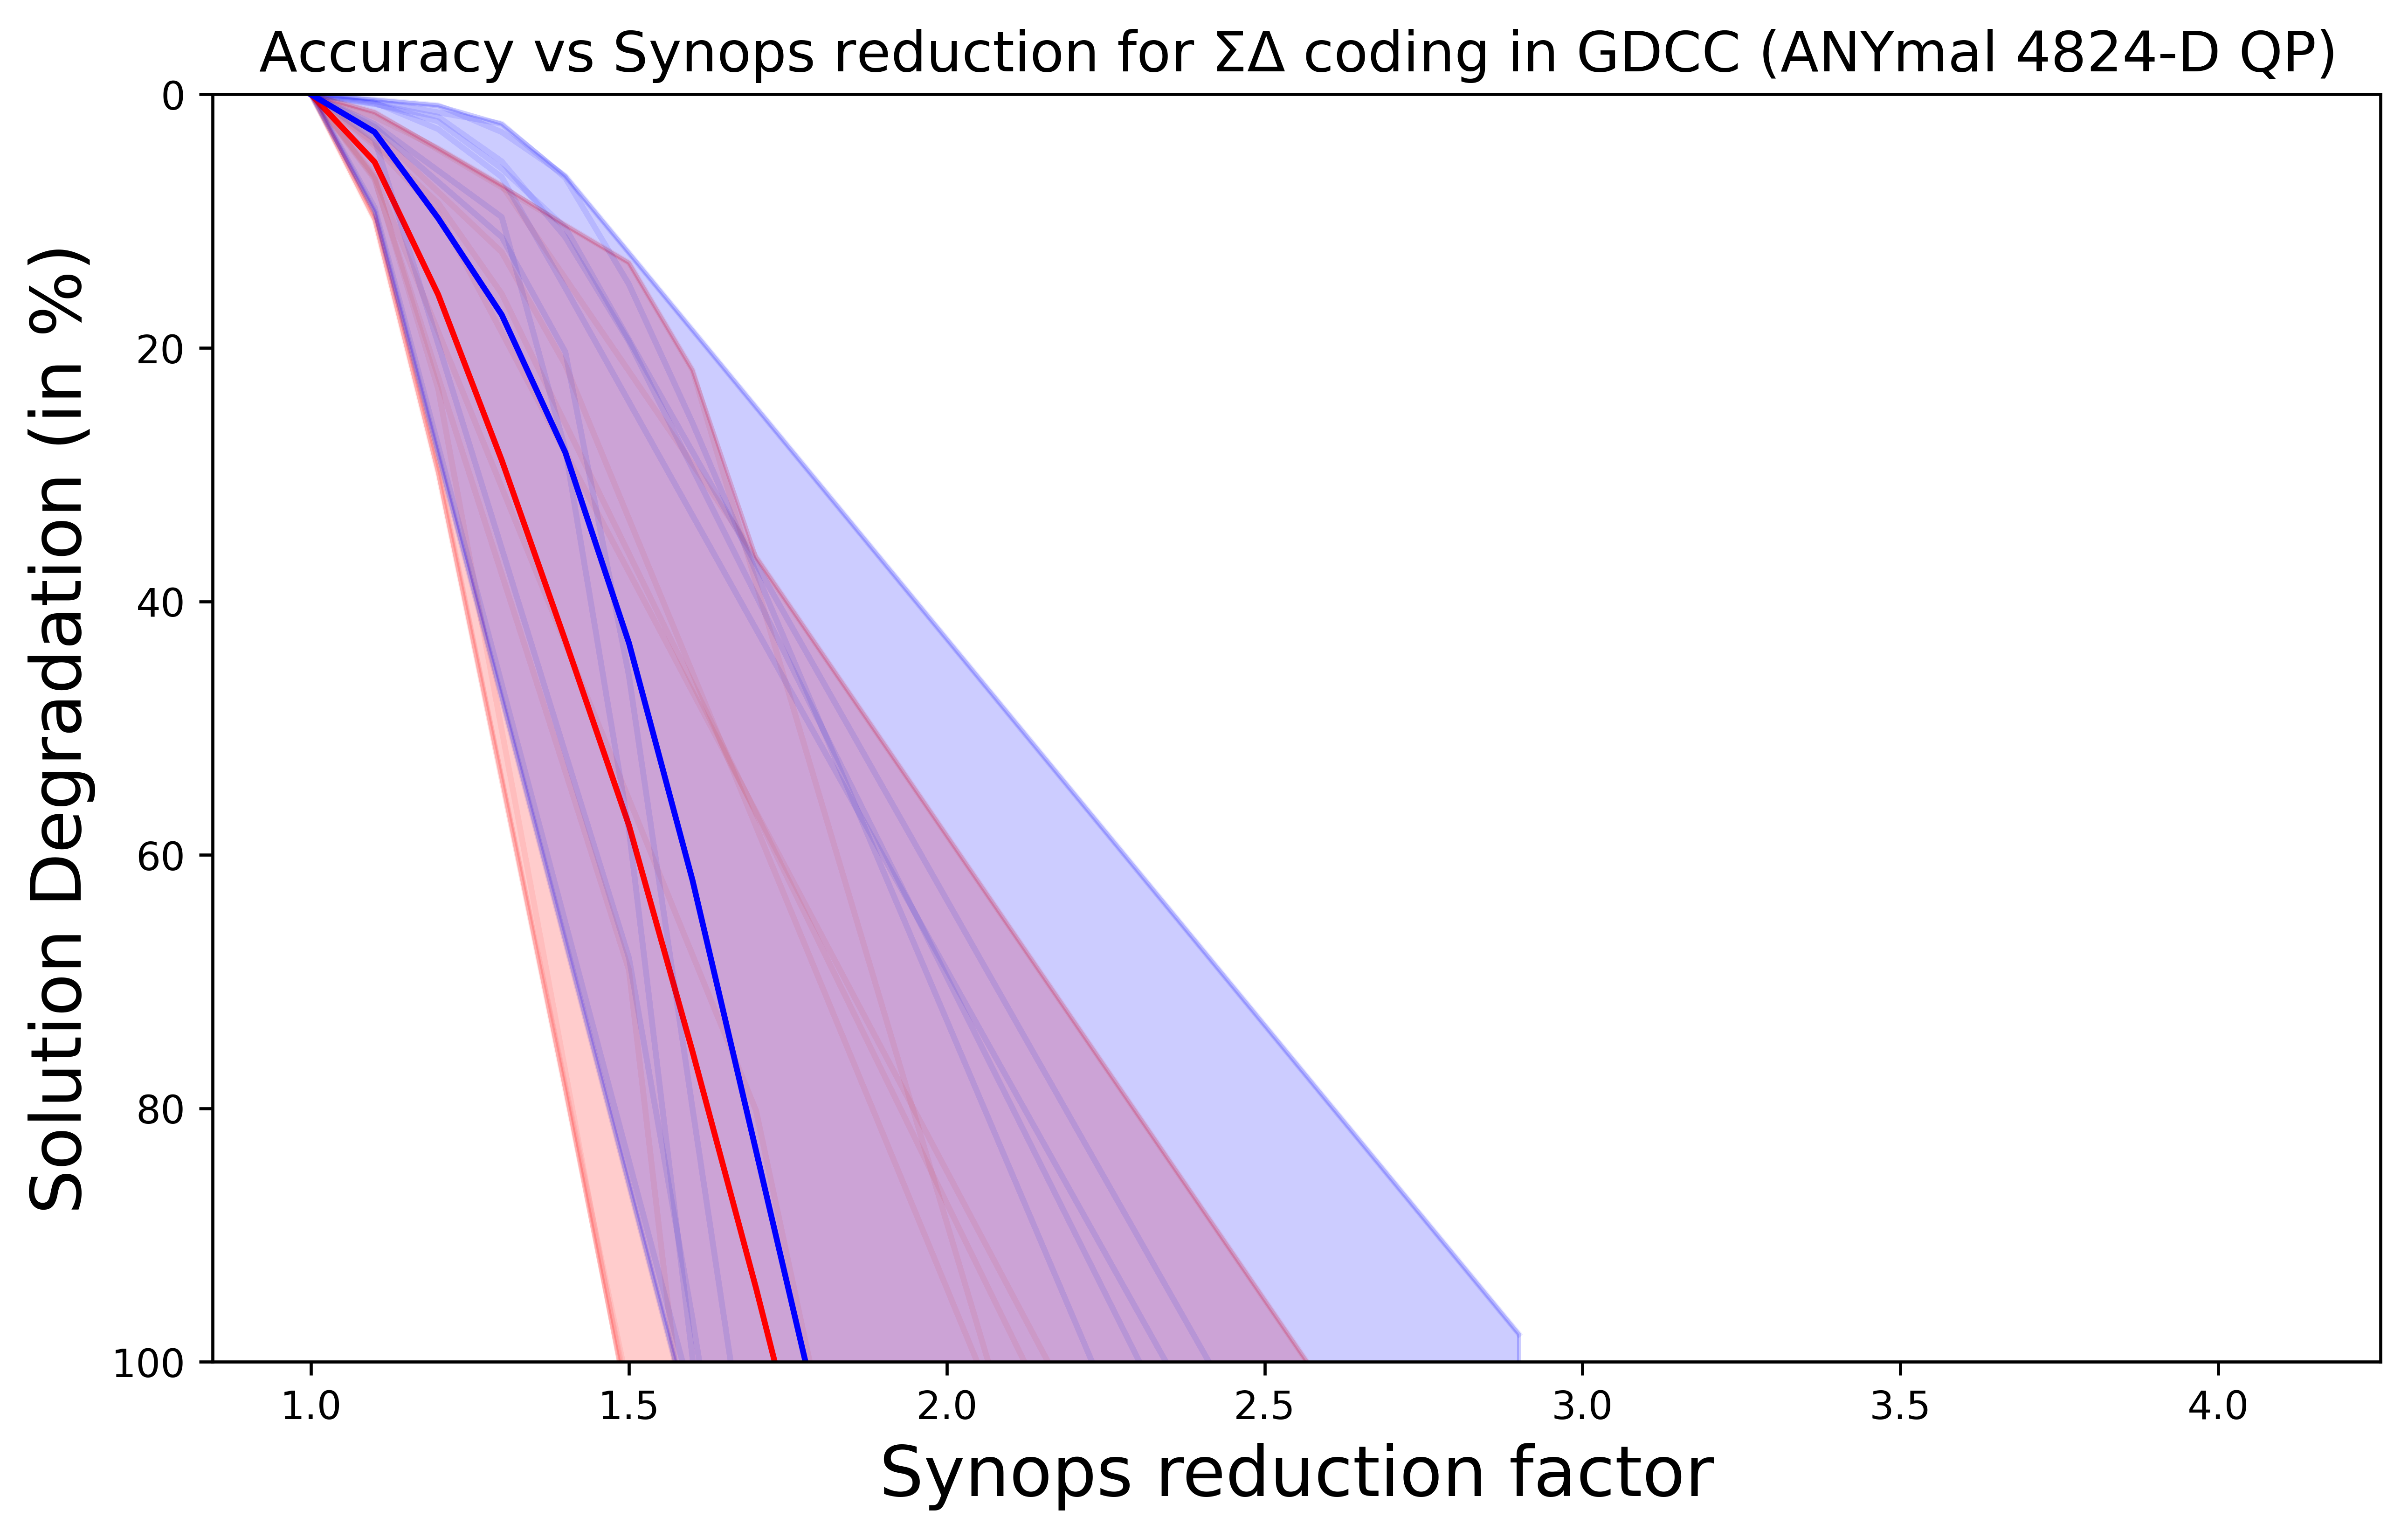

In [13]:
acc_ct_data = np.array(resampled_multi_prob_accuracy_red_ct)
std_ct_acc = np.std(acc_ct_data, axis=0)
mean_ct_acc = np.mean(acc_ct_data, axis=0)
min_ct_acc = np.min(acc_ct_data, axis=0)
max_ct_acc = np.max(acc_ct_data, axis=0) 

acc_at_data = np.array(resampled_multi_prob_accuracy_red_at)
std_at_acc = np.std(acc_at_data, axis=0)
mean_at_acc = np.mean(acc_at_data, axis=0)
min_at_acc = np.min(acc_at_data, axis=0)
max_at_acc = np.max(acc_at_data, axis=0) 


fig,ax = plt.subplots(figsize=(10, 6), dpi=600)
plt.rcParams.update({'font.size': 12})
plt.title("Accuracy vs Synops reduction for $ \Sigma \Delta $ coding in GDCC (ANYmal 4824-D QP)")
for accu_ct in resampled_multi_prob_accuracy_red_ct:
    ax.plot(x_axis_ct, accu_ct, color="red", alpha=0.01)
ax.plot(x_axis_ct, mean_ct_acc, color="red")
ax.fill_between(x_axis_ct, min_ct_acc, max_ct_acc, color='red', alpha=0.2)
ax.set_ylabel("Solution Degradation (in %)",color="black",fontsize=18)
ax.invert_yaxis()
ax.set_ylim(100,0)
for accu_at in resampled_multi_prob_accuracy_red_at:
    ax.plot(x_axis_at, accu_at, color="blue", alpha=0.01)
ax.plot(x_axis_at, mean_at_acc, color="blue")
ax.fill_between(x_axis_at, min_at_acc, max_at_acc, color='blue', alpha=0.2)
ax.set_xlabel("Synops reduction factor",fontsize=18)
# ax.legend(loc="center right")
plt.show()

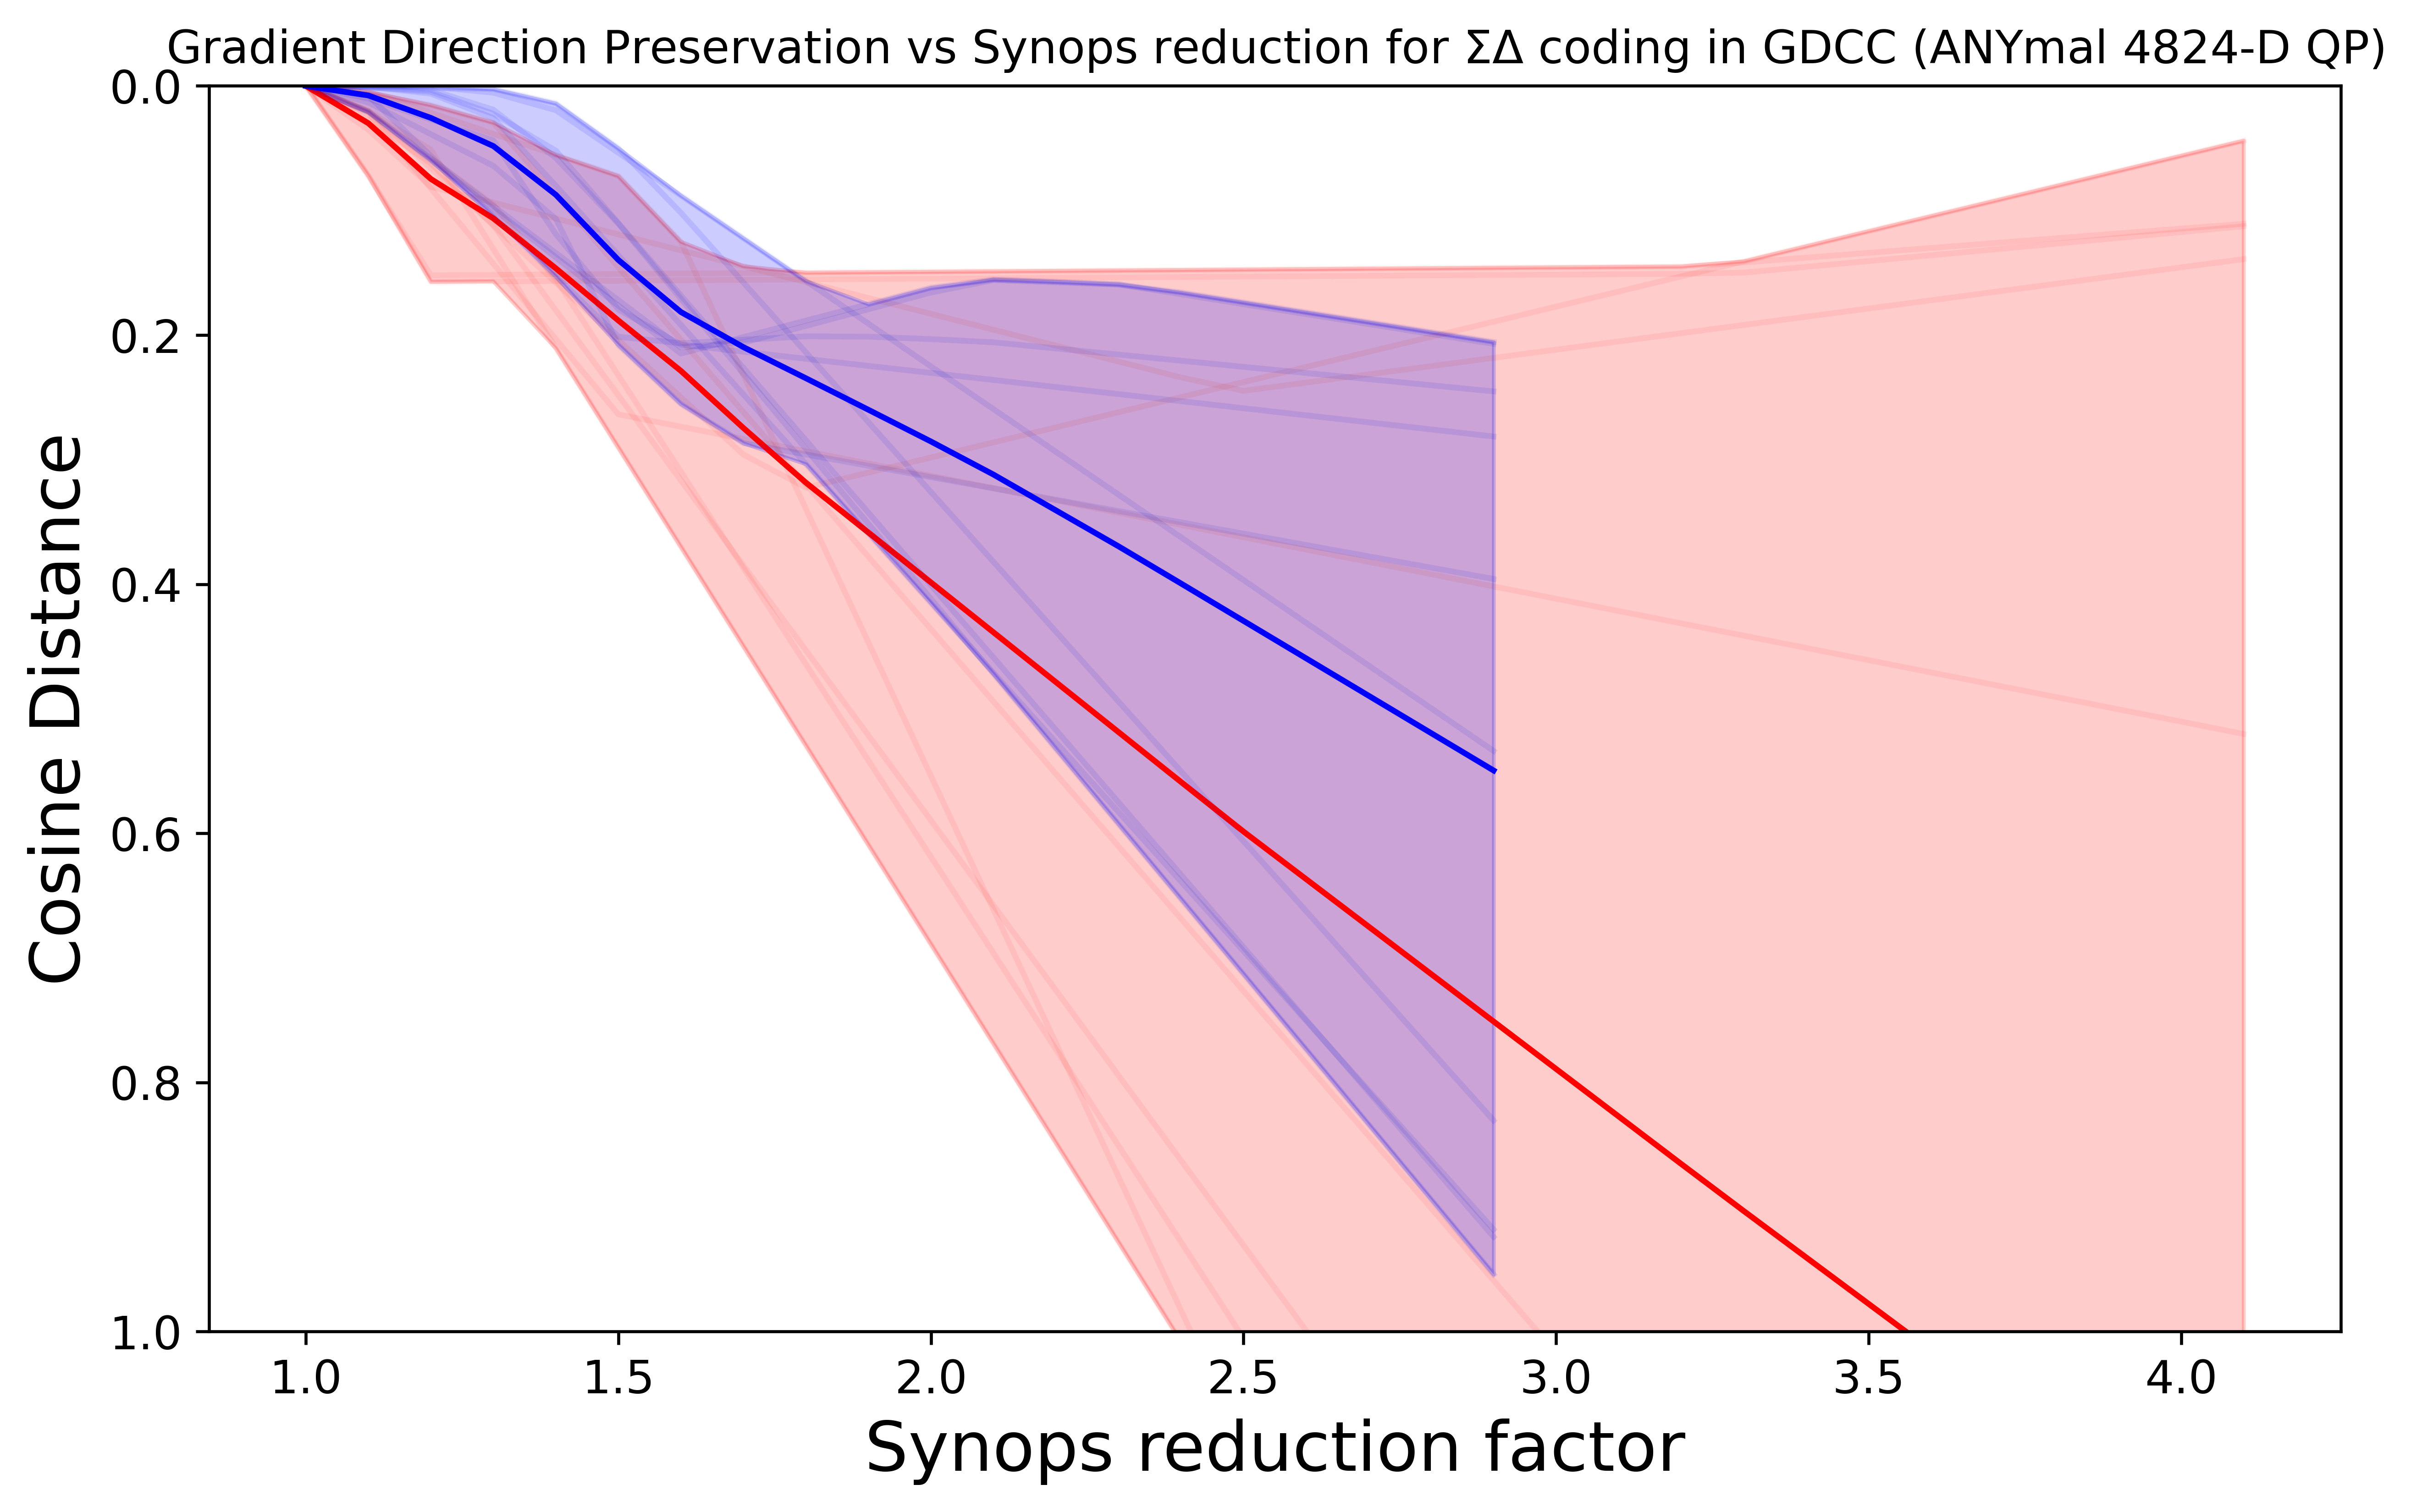

In [14]:
grad_ct_data = np.array(resampled_multi_prob_grad_dir_ct)
std_ct_grad = np.std(grad_ct_data, axis=0)
mean_ct_grad = np.mean(grad_ct_data, axis=0)
min_ct_grad = np.min(grad_ct_data, axis=0)
max_ct_grad = np.max(grad_ct_data, axis=0) 

grad_at_data = np.array(resampled_multi_prob_grad_dir_at)
std_at_grad = np.std(grad_at_data, axis=0)
mean_at_grad = np.mean(grad_at_data, axis=0)
min_at_grad = np.min(grad_at_data, axis=0)
max_at_grad = np.max(grad_at_data, axis=0) 

fig,ax = plt.subplots(figsize=(10, 6), dpi=600)
plt.rcParams.update({'font.size': 10})
plt.title("Gradient Direction Preservation vs Synops reduction for $ \Sigma \Delta $ coding in GDCC (ANYmal 4824-D QP)")

for grad_ct in resampled_multi_prob_grad_dir_ct:
    ax.plot(x_axis_ct, grad_ct, color="red", alpha=0.01)

ax.plot(x_axis_ct, mean_ct_grad, color="red")
ax.fill_between(x_axis_ct, min_ct_grad, max_ct_grad, color='red', alpha=0.2)

ax.set_ylabel("Cosine Distance",color="black",fontsize=18)
ax.invert_yaxis()
ax.set_ylim(1, 0)

for grad_at in resampled_multi_prob_grad_dir_at:
    ax.plot(x_axis_at, grad_at, color="blue", alpha=0.01)
    
ax.plot(x_axis_at, mean_at_grad, color="blue")
ax.fill_between(x_axis_at, min_at_grad, max_at_grad, color='blue', alpha=0.2)   

ax.set_xlabel("Synops reduction factor",fontsize=18)
#ax.legend(loc="center right")
plt.show()

### How to learn more?

Watch this [space](https://github.com/lava-nc/lava-optimization) to learn about upcoming developments to the QP solver and the optimization toolbox in Lava in general. 

If you want to find out more about the implementation of the QP solver, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava-optimization/tree/main/src/lava/lib/optimization/solvers/qp
"QP source code").
To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").